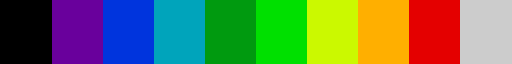

In [164]:
import zipfile
import json

from pathlib import Path

from torch.utils.data import Dataset
from skimage import io, transform
from pylab import cm
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import networkx as nx

ROOT_PATH = Path.cwd()
DATA_PATH = ROOT_PATH / '../data'
DATA_PATH.mkdir(parents=True, exist_ok=True)

NUM_LABELS = 24
COLORS = cm.get_cmap('nipy_spectral', 10)
COLORS

## Download dataset

In [22]:
_URL = 'https://storage.cloud.google.com/crowdstf-rico-uiuc-4540/rico_dataset_v0.1/semantic_annotations.zip'
# TODO: Do the code to download this zip file

In [24]:
with zipfile.ZipFile(DATA_PATH / 'semantic_annotations.zip', 'r') as zip_ref:
    zip_ref.extractall(DATA_PATH)

## Load files

In [64]:
class RICOSemanticAnnotationsDataset(Dataset):
    def __init__(self, root_dir: Path, transform=None):
        
        self.files = list((root_dir / 'semantic_annotations').glob('*.json'))
        self.root_dir = root_dir
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        
        with open(self.files[idx], 'r') as fp:
            json_file = json.load(fp)
            
        image = io.imread(self.files[idx].with_suffix('.png'))[:,: , :3] # Removing the Alpha channel
        
        return {'data': json_file, 'image': image}
            
        

### Data Transformations

In [118]:
def process_data(sample):
    def process_tree(root):
        return {
            'bbox': root['bounds'],
            'label': root.get('componentLabel', 'Screen'),
            'children': [process_tree(child) for child in root.get('children', [])]
        }
    
    return {
        **sample,
        'data': process_tree(sample['data'])
    }
    
def normalize_bboxes(sample):
    def normalize_bbox(root, w_factor, h_factor):
        return {
            **root,
            'bbox': [
                root['bbox'][0] * w_factor,
                root['bbox'][1] * h_factor,
                root['bbox'][2] * w_factor,
                root['bbox'][3] * h_factor
            ],
            'children': [normalize_bbox(child, w_factor, h_factor) for child in root.get('children', [])]
        }
        
    w_factor = 1 / sample['data']['bbox'][2]
    h_factor = 1 / sample['data']['bbox'][3]
    
    return {
        **sample,
        'data': normalize_bbox(sample['data'], w_factor, h_factor)
    }   
    
def add_networkx(sample):
    def convert_networkx(root, graph, parent_node):
        graph.add_node(graph.number_of_nodes() + 1, bbox=root['bbox'], label=root['label'])
        if parent_node:
            graph.add_edge(parent_node, graph.number_of_nodes(), label='parent_of')
            graph.add_edge(graph.number_of_nodes(), parent_node, label='child_of')
        
        parent = graph.number_of_nodes()
        for child in root.get('children', []):
            graph = convert_networkx(child, graph, parent)
            
        return graph
            
    G = nx.DiGraph()
    G = convert_networkx(sample['data'], graph=G, parent_node=None)
    return {
        **sample,
        'graph': G
    }
        

In [119]:
rico_dataset = RICOSemanticAnnotationsDataset(root_dir=DATA_PATH)

In [174]:
datapoint = add_networkx(normalize_bboxes(process_data(rico_dataset[0])))

In [175]:
color_node_map, color_label_map = [], {}
for node, data in datapoint['graph'].nodes(data=True):
    if data['label'] not in color_label_map:
        color_label_map[data['label']] = COLORS(len(color_label_map))
    
    color_node_map.append(color_label_map[data['label']])

In [180]:
def draw_screen(root, ax, color_label_map, queue=[]):
    queue.extend(root.get('children', []))
    while queue:
        child = queue.pop(0)
    
        w, h = child['bbox'][2] - child['bbox'][0], child['bbox'][3] - child['bbox'][1]
        rect = patches.Rectangle((child['bbox'][0], child['bbox'][1]), w, h, facecolor=color_label_map[child['label']])
        ax.add_patch(rect)
        draw_screen(child, ax, color_label_map, queue=queue)

        

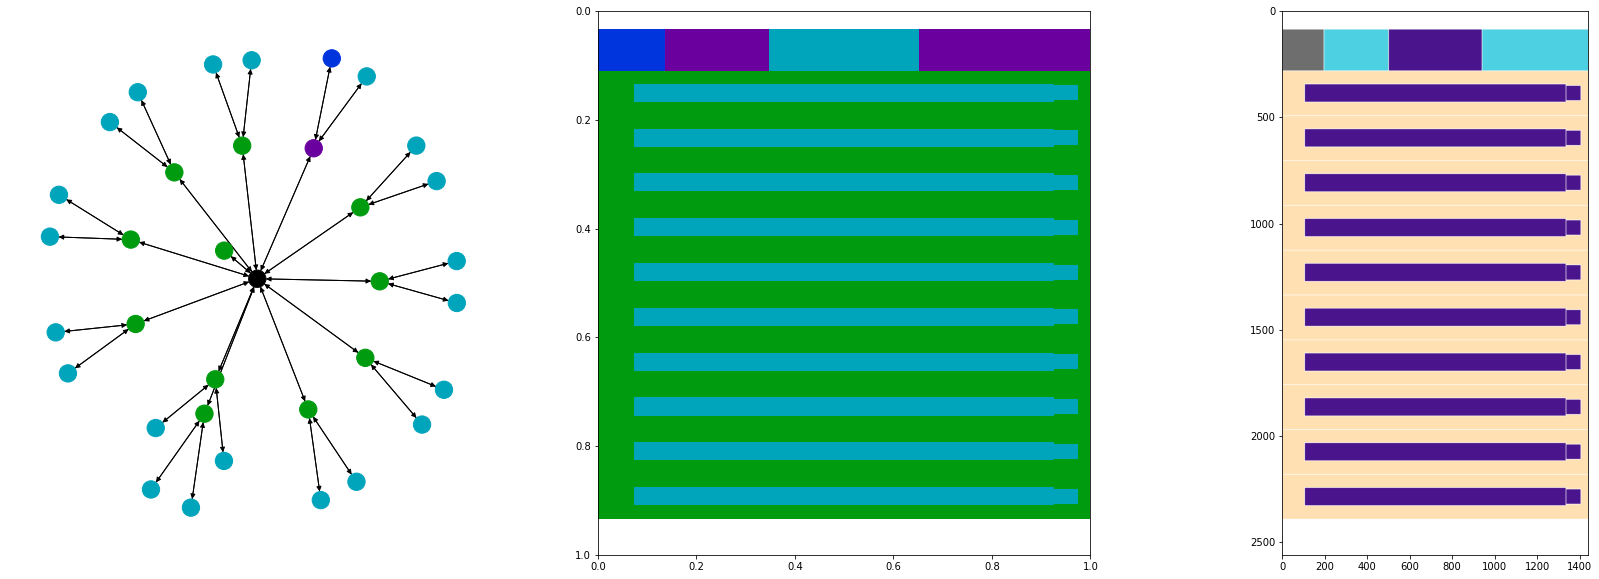

In [181]:
fig, axes = plt.subplots(1, 3, figsize=(30, 10))
axes[1].invert_yaxis()
draw_screen(datapoint['data'], axes[1], color_label_map)
axes[2].imshow(datapoint['image'])
nx.draw(datapoint['graph'], node_color=color_node_map, ax=axes[0])

In [122]:
datapoint['graph'].nodes[1]

{'bbox': [0.0, 0.0, 1.0, 1.0], 'label': 'Screen'}

In [186]:
rico_dataset[0]['data']

{'ancestors': ['android.widget.FrameLayout',
  'android.view.ViewGroup',
  'android.view.View',
  'java.lang.Object'],
 'class': 'com.android.internal.policy.PhoneWindow$DecorView',
 'bounds': [0, 0, 1440, 2560],
 'clickable': False,
 'children': [{'resource-id': 'com.siplay.tourneymachine_android:id/toolbar',
   'children': [{'iconClass': 'arrow_backward',
     'ancestors': ['android.widget.ImageButton',
      'android.widget.ImageView',
      'android.view.View',
      'java.lang.Object'],
     'bounds': [0, 84, 196, 280],
     'clickable': True,
     'class': 'android.support.v7.widget.AppCompatImageButton',
     'componentLabel': 'Icon'},
    {'text': 'Select Location',
     'resource-id': 'com.siplay.tourneymachine_android:id/home_toolbar_title',
     'ancestors': ['android.widget.TextView',
      'android.view.View',
      'java.lang.Object'],
     'clickable': False,
     'class': 'android.support.v7.widget.AppCompatTextView',
     'bounds': [500, 84, 940, 280],
     'componentL

In [ ]:
rico_dataset[0].meta